In [1]:
import tensorflow as tf

print(tf.__version__)

from tensorflow.keras.models                import Sequential, Model
from tensorflow.keras.layers                import *
from tensorflow.keras.preprocessing.image   import ImageDataGenerator
from tensorflow.keras.utils                 import to_categorical
from tensorflow.keras.optimizers            import SGD, RMSprop, Adam, Adagrad, Adadelta

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import random
# import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn
import scipy
import skimage
from skimage.transform import resize
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

2023-09-09 21:26:40.946417: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-09 21:26:44.992021: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-09 21:26:53.196562: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-09 21:26:53.196818: W tensorflow/strea

2.10.1


In [13]:
!git clone https://github.com/ardamavi/Sign-Language-Digits-Dataset.git

Cloning into 'Sign-Language-Digits-Dataset'...
remote: Enumerating objects: 2095, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 2095 (delta 2), reused 0 (delta 0), pack-reused 2089
Receiving objects: 100% (2095/2095), 15.07 MiB | 37.27 MiB/s, done.
Resolving deltas: 100% (660/660), done.


In [15]:
!pip install split-folders 

In [16]:
import splitfolders
import os

In [17]:
path = "Sign-Language-Digits-Dataset/Dataset"

splitfolders.ratio(path, seed=777, output="Train-Validation-Test-Dataset", ratio=(0.7, 0.15, 0.15))

Copying files: 2062 files [00:00, 7405.55 files/s]


In [18]:
train_path = "Train-Validation-Test-Dataset/train"
val_path = "Train-Validation-Test-Dataset/val"
test_path = "Train-Validation-Test-Dataset/test"

In [19]:
from tensorflow.keras.preprocessing.image   import ImageDataGenerator

##Clasificamos las imagenes
bs = 32 #bach size
k = 2
# Generador de imágenes de entrenamiento.
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=(0.3),
        zoom_range=(0.3),
        width_shift_range=(0.2),
        height_shift_range=(0.2),
        # validation_split = 0.2,
        brightness_range=(0.05,0.85),
        horizontal_flip=False)

# Carga de imágenes al generador de entrenamiento desde directorio.
train_generator = train_datagen.flow_from_directory(
        train_path,
        class_mode='categorical',
        shuffle=True,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'training',
        batch_size=bs)

valid_generator = train_datagen.flow_from_directory(
        val_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

test_generator = train_datagen.flow_from_directory(
        test_path,
        class_mode='categorical',
        shuffle=False,
        target_size=(28*k, 28*k),
        color_mode = 'rgb', 
        # subset = 'validation',
        batch_size=bs)

Found 1438 images belonging to 10 classes.
Found 304 images belonging to 10 classes.
Found 320 images belonging to 10 classes.


In [20]:
#Visualizamos la estructura del modelo que vamos a utilizar
model = tf.keras.applications.VGG19()
model.summary()
print(len(model.layers))

2023-09-09 21:39:35.521547: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-09-09 21:39:35.547306: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-09 21:39:35.547386: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (7afc8bd065ce): /proc/driver/nvidia/version does not exist
2023-09-09 21:39:35.564028: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in 

574710816/574710816 [==============================] - 4s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [22]:
##DEFINIMOS EL MODELO
num_classes = 10
epochs = 50

# VGG19
# Importamos el modelo que queremos utilizar con los argumentos que queremos
VGG19_model = tf.keras.applications.VGG19(input_shape=(28*k,28*k,3),
                                          include_top=False,
                                          weights='imagenet')

print(len(VGG19_model.layers))
#Congelamos  las 6 primeras caps del modelo para proceder a entrenar las demás
for layer in VGG19_model.layers[:6]:
  layer.trainable = False

# Creamos un nuevo modelo vacio.
model = tf.keras.Sequential()

# Añadimos el modelo preentrenado como si se tratase de una capa.
model.add(VGG19_model)

# Continuamos añadiendo más capas que sí serán entrenadas...
from tensorflow.keras import regularizers
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(64, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation = 'softmax'))

80134624/80134624 [==============================] - 1s 0us/step
22


In [26]:
## EJECUCION DEL MODELO
model.compile(loss="categorical_crossentropy", 
              optimizer= SGD(learning_rate=0.001),
              metrics=['accuracy'])

#Agregamos un callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

checkpointer = ModelCheckpoint(filepath='model-00', verbose=1, save_best_only=True,
                               monitor = 'accuracy', mode = 'max')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=3, min_lr=0.000001)

history= model.fit(train_generator, callbacks = [reduce_lr, checkpointer], epochs=epochs)

Epoch 1/50
45/45 [==============================] - ETA: 0s - loss: 2.5273 - accuracy: 0.5028
Epoch 1: accuracy improved from -inf to 0.50278, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 100s 2s/step - loss: 2.5273 - accuracy: 0.5028 - lr: 0.0010
Epoch 2/50
45/45 [==============================] - ETA: 0s - loss: 2.3848 - accuracy: 0.5542
Epoch 2: accuracy improved from 0.50278 to 0.55424, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 97s 2s/step - loss: 2.3848 - accuracy: 0.5542 - lr: 0.0010
Epoch 3/50
45/45 [==============================] - ETA: 0s - loss: 2.2354 - accuracy: 0.5932
Epoch 3: accuracy improved from 0.55424 to 0.59319, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 99s 2s/step - loss: 2.2354 - accuracy: 0.5932 - lr: 0.0010
Epoch 4/50
45/45 [==============================] - ETA: 0s - loss: 2.1327 - accuracy: 0.6384
Epoch 4: accuracy improved from 0.59319 to 0.63839, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 99s 2s/step - loss: 2.1327 - accuracy: 0.6384 - lr: 0.0010
Epoch 5/50
45/45 [==============================] - ETA: 0s - loss: 1.9865 - accuracy: 0.6926
Epoch 5: accuracy improved from 0.63839 to 0.69263, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 98s 2s/step - loss: 1.9865 - accuracy: 0.6926 - lr: 0.0010
Epoch 6/50
45/45 [==============================] - ETA: 0s - loss: 1.9148 - accuracy: 0.7177
Epoch 6: accuracy improved from 0.69263 to 0.71766, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 99s 2s/step - loss: 1.9148 - accuracy: 0.7177 - lr: 0.0010
Epoch 7/50
45/45 [==============================] - ETA: 0s - loss: 1.8773 - accuracy: 0.7469
Epoch 7: accuracy improved from 0.71766 to 0.74687, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 100s 2s/step - loss: 1.8773 - accuracy: 0.7469 - lr: 0.0010
Epoch 8/50
45/45 [==============================] - ETA: 0s - loss: 1.7768 - accuracy: 0.7761
Epoch 8: accuracy improved from 0.74687 to 0.77608, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 100s 2s/step - loss: 1.7768 - accuracy: 0.7761 - lr: 0.0010
Epoch 9/50
45/45 [==============================] - ETA: 0s - loss: 1.7706 - accuracy: 0.7837
Epoch 9: accuracy improved from 0.77608 to 0.78373, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 99s 2s/step - loss: 1.7706 - accuracy: 0.7837 - lr: 0.0010
Epoch 10/50
45/45 [==============================] - ETA: 0s - loss: 1.6395 - accuracy: 0.8178
Epoch 10: accuracy improved from 0.78373 to 0.81780, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 99s 2s/step - loss: 1.6395 - accuracy: 0.8178 - lr: 0.0010
Epoch 11/50
45/45 [==============================] - ETA: 0s - loss: 1.6090 - accuracy: 0.8401
Epoch 11: accuracy improved from 0.81780 to 0.84006, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 101s 2s/step - loss: 1.6090 - accuracy: 0.8401 - lr: 0.0010
Epoch 12/50
45/45 [==============================] - ETA: 0s - loss: 1.5837 - accuracy: 0.8519
Epoch 12: accuracy improved from 0.84006 to 0.85188, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 100s 2s/step - loss: 1.5837 - accuracy: 0.8519 - lr: 0.0010
Epoch 13/50
45/45 [==============================] - ETA: 0s - loss: 1.5563 - accuracy: 0.8512
Epoch 13: accuracy did not improve from 0.85188
45/45 [==============================] - 97s 2s/step - loss: 1.5563 - accuracy: 0.8512 - lr: 0.0010
Epoch 14/50
45/45 [==============================] - ETA: 0s - loss: 1.5002 - accuracy: 0.8693
Epoch 14: accuracy improved from 0.85188 to 0.86926, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 103s 2s/step - loss: 1.5002 - accuracy: 0.8693 - lr: 0.0010
Epoch 15/50
45/45 [==============================] - ETA: 0s - loss: 1.4898 - accuracy: 0.8707
Epoch 15: accuracy improved from 0.86926 to 0.87065, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 104s 2s/step - loss: 1.4898 - accuracy: 0.8707 - lr: 0.0010
Epoch 16/50
45/45 [==============================] - ETA: 0s - loss: 1.4607 - accuracy: 0.8839
Epoch 16: accuracy improved from 0.87065 to 0.88387, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 103s 2s/step - loss: 1.4607 - accuracy: 0.8839 - lr: 0.0010
Epoch 17/50
45/45 [==============================] - ETA: 0s - loss: 1.4368 - accuracy: 0.8943
Epoch 17: accuracy improved from 0.88387 to 0.89430, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 100s 2s/step - loss: 1.4368 - accuracy: 0.8943 - lr: 0.0010
Epoch 18/50
45/45 [==============================] - ETA: 0s - loss: 1.4491 - accuracy: 0.8776
Epoch 18: accuracy did not improve from 0.89430
45/45 [==============================] - 97s 2s/step - loss: 1.4491 - accuracy: 0.8776 - lr: 0.0010
Epoch 19/50
45/45 [==============================] - ETA: 0s - loss: 1.4159 - accuracy: 0.8950
Epoch 19: accuracy improved from 0.89430 to 0.89499, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 100s 2s/step - loss: 1.4159 - accuracy: 0.8950 - lr: 0.0010
Epoch 20/50
45/45 [==============================] - ETA: 0s - loss: 1.4194 - accuracy: 0.8936
Epoch 20: accuracy did not improve from 0.89499
45/45 [==============================] - 94s 2s/step - loss: 1.4194 - accuracy: 0.8936 - lr: 0.0010
Epoch 21/50
45/45 [==============================] - ETA: 0s - loss: 1.3589 - accuracy: 0.9103
Epoch 21: accuracy improved from 0.89499 to 0.91029, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 100s 2s/step - loss: 1.3589 - accuracy: 0.9103 - lr: 0.0010
Epoch 22/50
45/45 [==============================] - ETA: 0s - loss: 1.3691 - accuracy: 0.9131
Epoch 22: accuracy improved from 0.91029 to 0.91307, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 97s 2s/step - loss: 1.3691 - accuracy: 0.9131 - lr: 0.0010
Epoch 23/50
45/45 [==============================] - ETA: 0s - loss: 1.3565 - accuracy: 0.9159
Epoch 23: accuracy improved from 0.91307 to 0.91586, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 95s 2s/step - loss: 1.3565 - accuracy: 0.9159 - lr: 0.0010
Epoch 24/50
45/45 [==============================] - ETA: 0s - loss: 1.3318 - accuracy: 0.9256
Epoch 24: accuracy improved from 0.91586 to 0.92559, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 98s 2s/step - loss: 1.3318 - accuracy: 0.9256 - lr: 0.0010
Epoch 25/50
45/45 [==============================] - ETA: 0s - loss: 1.3136 - accuracy: 0.9277
Epoch 25: accuracy improved from 0.92559 to 0.92768, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 101s 2s/step - loss: 1.3136 - accuracy: 0.9277 - lr: 0.0010
Epoch 26/50
45/45 [==============================] - ETA: 0s - loss: 1.3001 - accuracy: 0.9353
Epoch 26: accuracy improved from 0.92768 to 0.93533, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 100s 2s/step - loss: 1.3001 - accuracy: 0.9353 - lr: 0.0010
Epoch 27/50
45/45 [==============================] - ETA: 0s - loss: 1.3041 - accuracy: 0.9339
Epoch 27: accuracy did not improve from 0.93533
45/45 [==============================] - 101s 2s/step - loss: 1.3041 - accuracy: 0.9339 - lr: 0.0010
Epoch 28/50
45/45 [==============================] - ETA: 0s - loss: 1.3215 - accuracy: 0.9284
Epoch 28: accuracy did not improve from 0.93533
45/45 [==============================] - 104s 2s/step - loss: 1.3215 - accuracy: 0.9284 - lr: 0.0010
Epoch 29/50
45/45 [==============================] - ETA: 0s - loss: 1.2772 - accuracy: 0.9374
Epoch 29: accuracy improved from 0.93533 to 0.93741, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 105s 2s/step - loss: 1.2772 - accuracy: 0.9374 - lr: 0.0010
Epoch 30/50
45/45 [==============================] - ETA: 0s - loss: 1.2662 - accuracy: 0.9430
Epoch 30: accuracy improved from 0.93741 to 0.94298, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 107s 2s/step - loss: 1.2662 - accuracy: 0.9430 - lr: 0.0010
Epoch 31/50
45/45 [==============================] - ETA: 0s - loss: 1.2890 - accuracy: 0.9381
Epoch 31: accuracy did not improve from 0.94298
45/45 [==============================] - 101s 2s/step - loss: 1.2890 - accuracy: 0.9381 - lr: 0.0010
Epoch 32/50
45/45 [==============================] - ETA: 0s - loss: 1.2665 - accuracy: 0.9312
Epoch 32: accuracy did not improve from 0.94298
45/45 [==============================] - 98s 2s/step - loss: 1.2665 - accuracy: 0.9312 - lr: 0.0010
Epoch 33/50
45/45 [==============================] - ETA: 0s - loss: 1.2460 - accuracy: 0.9423
Epoch 33: accuracy did not improve from 0.94298
45/45 [==============================] - 99s 2s/step - loss: 1.2460 - accuracy: 0.9423 - lr: 0.0010
Epoch 34/50
45/45 [==============================] - ETA: 0s - loss: 1.2695 - accuracy: 0.9374
Epoch 34: accuracy did not improve from 0.94298
45/45 [===================

INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 98s 2s/step - loss: 1.2369 - accuracy: 0.9478 - lr: 0.0010
Epoch 36/50
45/45 [==============================] - ETA: 0s - loss: 1.2446 - accuracy: 0.9478
Epoch 36: accuracy did not improve from 0.94784
45/45 [==============================] - 100s 2s/step - loss: 1.2446 - accuracy: 0.9478 - lr: 0.0010
Epoch 37/50
45/45 [==============================] - ETA: 0s - loss: 1.2267 - accuracy: 0.9541
Epoch 37: accuracy improved from 0.94784 to 0.95410, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 103s 2s/step - loss: 1.2267 - accuracy: 0.9541 - lr: 0.0010
Epoch 38/50
45/45 [==============================] - ETA: 0s - loss: 1.2171 - accuracy: 0.9541
Epoch 38: accuracy did not improve from 0.95410
45/45 [==============================] - 98s 2s/step - loss: 1.2171 - accuracy: 0.9541 - lr: 0.0010
Epoch 39/50
45/45 [==============================] - ETA: 0s - loss: 1.2166 - accuracy: 0.9569
Epoch 39: accuracy improved from 0.95410 to 0.95688, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 101s 2s/step - loss: 1.2166 - accuracy: 0.9569 - lr: 0.0010
Epoch 40/50
45/45 [==============================] - ETA: 0s - loss: 1.2205 - accuracy: 0.9465
Epoch 40: accuracy did not improve from 0.95688
45/45 [==============================] - 98s 2s/step - loss: 1.2205 - accuracy: 0.9465 - lr: 0.0010
Epoch 41/50
45/45 [==============================] - ETA: 0s - loss: 1.2118 - accuracy: 0.9506
Epoch 41: accuracy did not improve from 0.95688
45/45 [==============================] - 96s 2s/step - loss: 1.2118 - accuracy: 0.9506 - lr: 0.0010
Epoch 42/50
45/45 [==============================] - ETA: 0s - loss: 1.1853 - accuracy: 0.9611
Epoch 42: accuracy improved from 0.95688 to 0.96106, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 100s 2s/step - loss: 1.1853 - accuracy: 0.9611 - lr: 0.0010
Epoch 43/50
45/45 [==============================] - ETA: 0s - loss: 1.1844 - accuracy: 0.9513
Epoch 43: accuracy did not improve from 0.96106
45/45 [==============================] - 96s 2s/step - loss: 1.1844 - accuracy: 0.9513 - lr: 0.0010
Epoch 44/50
45/45 [==============================] - ETA: 0s - loss: 1.1807 - accuracy: 0.9604
Epoch 44: accuracy did not improve from 0.96106
45/45 [==============================] - 96s 2s/step - loss: 1.1807 - accuracy: 0.9604 - lr: 0.0010
Epoch 45/50
45/45 [==============================] - ETA: 0s - loss: 1.2063 - accuracy: 0.9499
Epoch 45: accuracy did not improve from 0.96106
45/45 [==============================] - 95s 2s/step - loss: 1.2063 - accuracy: 0.9499 - lr: 0.0010
Epoch 46/50
45/45 [==============================] - ETA: 0s - loss: 1.1842 - accuracy: 0.9597
Epoch 46: accuracy did not improve from 0.96106
45/45 [====================

INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 102s 2s/step - loss: 1.1790 - accuracy: 0.9618 - lr: 0.0010
Epoch 48/50
45/45 [==============================] - ETA: 0s - loss: 1.1819 - accuracy: 0.9645
Epoch 48: accuracy improved from 0.96175 to 0.96453, saving model to model-00


INFO:tensorflow:Assets written to: model-00/assets


INFO:tensorflow:Assets written to: model-00/assets


45/45 [==============================] - 100s 2s/step - loss: 1.1819 - accuracy: 0.9645 - lr: 0.0010
Epoch 49/50
45/45 [==============================] - ETA: 0s - loss: 1.1716 - accuracy: 0.9604
Epoch 49: accuracy did not improve from 0.96453
45/45 [==============================] - 96s 2s/step - loss: 1.1716 - accuracy: 0.9604 - lr: 0.0010
Epoch 50/50
45/45 [==============================] - ETA: 0s - loss: 1.1700 - accuracy: 0.9590
Epoch 50: accuracy did not improve from 0.96453
45/45 [==============================] - 99s 2s/step - loss: 1.1700 - accuracy: 0.9590 - lr: 0.0010


In [28]:
preds_test = model.predict(test_generator)

10/10 [==============================] - 7s 644ms/step


In [29]:
evaluate_test = model.evaluate(test_generator)

10/10 [==============================] - 7s 640ms/step - loss: 1.1685 - accuracy: 0.9656


In [30]:
evaluate_test

[1.1685106754302979, 0.965624988079071]

In [31]:
y_preds_test = np.array([np.argmax(x) for x in preds_test])
y_preds_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 5, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 6, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [32]:
y_real_test = test_generator.classes
y_real_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [33]:
accuracy_test = accuracy_score(y_real_test, y_preds_test)
accuracy_test

0.965625

In [34]:
cm_test = confusion_matrix(y_real_test, y_preds_test)
cm_test

array([[32,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 32,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 30,  1,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0, 32,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 29,  3,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1, 31,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 32,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  1, 28,  2,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 31,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 32]])

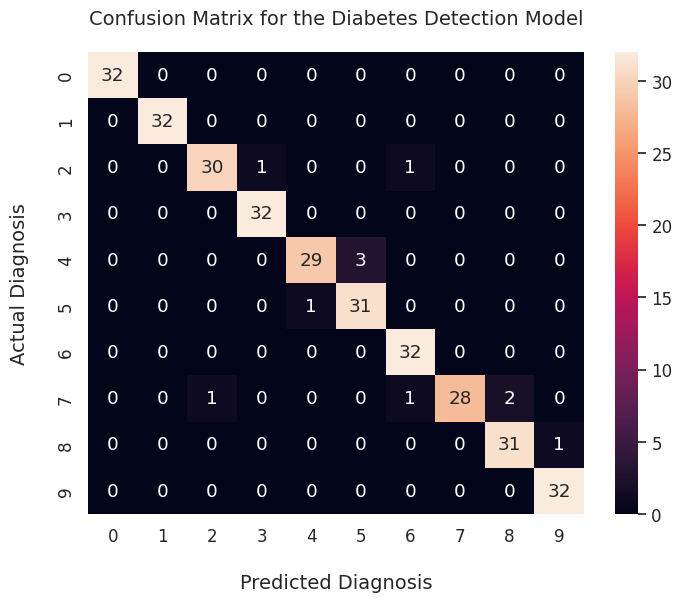

In [35]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_test, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()

In [36]:
preds_val = model.predict(valid_generator)

10/10 [==============================] - 7s 650ms/step


In [37]:
evaluate_val = model.evaluate(valid_generator)

10/10 [==============================] - 6s 576ms/step - loss: 1.1880 - accuracy: 0.9474


In [38]:
evaluate_val

[1.188027024269104, 0.9473684430122375]

In [39]:
y_preds_val = np.array([np.argmax(x) for x in preds_val])
y_preds_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7,
       6, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8,
       7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [40]:
y_real_val = valid_generator.classes
y_real_val

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,

In [41]:
accuracy_val = accuracy_score(y_real_val, y_preds_val)
accuracy_val

0.9736842105263158

In [42]:
cm_val = confusion_matrix(y_real_val, y_preds_val)
cm_val

array([[30,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 30,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 28,  1,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0, 29,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 30,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 31,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 31,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1, 27,  2,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0, 30,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 30]])

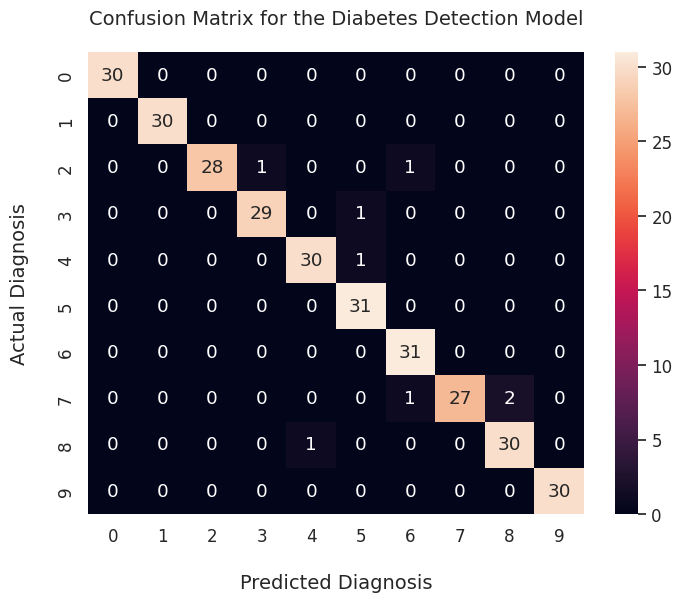

In [43]:
plt.figure(figsize=(8,6), dpi=100)
# Scale up the size of all text
sns.set(font_scale = 1.1)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# first param - confusion matrix in array format   
# annot = True: show the numbers in each heatmap cell
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm_val, annot=True, fmt='d', )

# set x-axis label and ticks. 
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
# ax.xaxis.set_ticklabels(['Negative', 'Positive'])

# set y-axis label and ticks
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
# ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# set plot title
ax.set_title("Confusion Matrix for the Diabetes Detection Model", fontsize=14, pad=20)

plt.show()